# ClimateNet AR Analysis: Runoff

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import matplotlib.colors as mcolors
import matplotlib as mpl

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
nmem1 = '10GiB' # PBSCluster specification
nmem2 = '10GB' # pbs specification
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory=nmem1, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your local directory
    resource_spec='select=1:ncpus=1:mem='+nmem2, # Specify resources
    account='P06010014', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
cluster.scale(10)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
# the above is for jupyterhub only, otherwise use /proxy/{port}/status (also need to launch ssh tunneling from the appropriate environment)
#dask.config.set({'distributed.dashboard.link': "/proxy/{port}/status"})
# really I should set these options in some sort of config file...

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34266 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.12.206.49:35189' processes=10 threads=10, memory=100.00 GiB>

## Set ClimateNet filepath

In [4]:
cesm_cnet_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/" # retrained NCAR model, after data processing workflow was finalized

## Set regional bounds

In [5]:
# Western US domain from Payne & Magnusdottir (2014,2015) papers (estimated, modified to include land at all lons)
#lat_bounds = slice(25,61)
#lon_bounds = slice(189, 250)

# Restricted western US (mostly land) domain from Collow et al. 2020
#lat_bounds = slice(32,50)
#lon_bounds = slice(235,246)

# Western US/Eastern Pacific domain from ARTMIP
lat_bounds = slice(25,65)
lon_bounds = slice(180,250)

### Preprocessing function to subset regionally

In [6]:
def preprocess_region(ds):
    # return regional domain
    return ds['masks'].sel(lat=lat_bounds,lon=lon_bounds)

## CESM historical simulation

In [7]:
hist_yrs = [str(i) for i in range(2000,2006)]
#hist_folders = ["B20TRC5CN/"+y+"/masks/" for y in hist_yrs]
hist_folders = ["B20TRC5CN/"+y+"/masks_unwgt/" for y in hist_yrs] # unweighted means/std

In [8]:
cnet_file = 'class_masks.nc' # can't use wildcard for this to work?
hist_paths = [cesm_cnet_filepath+hist_folders[i]+cnet_file for i,f in enumerate(hist_folders)]
hist_paths

['/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2000/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2001/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2002/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2003/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2004/masks_unwgt/class_masks.nc',
 '/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/2005/masks_unwgt/class_masks.nc']

### Read in masks with preprocessing

In [9]:
%%time
cnet_hist_shift = xr.open_mfdataset(hist_paths, concat_dim='time',combine='nested', chunks={'time':500}, parallel=True, preprocess=preprocess_region)

CPU times: user 1.2 s, sys: 305 ms, total: 1.51 s
Wall time: 15.6 s


In [10]:
cnet_hist_shift

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 03:00:00 ... 2006-01-01 00:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

### Shift time indices of 2000-2005 back 3hrs to avoid duplicative index

In [11]:
timeshift = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"H")

In [12]:
timeshift

CFTimeIndex([2000-01-01 00:00:00, 2000-01-01 03:00:00, 2000-01-01 06:00:00,
             2000-01-01 09:00:00, 2000-01-01 12:00:00, 2000-01-01 15:00:00,
             2000-01-01 18:00:00, 2000-01-01 21:00:00, 2000-01-02 00:00:00,
             2000-01-02 03:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17520, calendar='noleap', freq='3H')

In [13]:
cnet_hist = cnet_hist_shift.sel(time=slice("2000-01-01 03:00:00","2006-01-01 00:00:00")).assign_coords(time=timeshift)
cnet_hist

<xarray.DataArray 'masks' (time: 17520, lat: 170, lon: 225)>
dask.array<concatenate, shape=(17520, 170, 225), dtype=int64, chunksize=(500, 170, 225), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * time     (time) object 2000-01-01 00:00:00 ... 2005-12-31 21:00:00
Attributes: (12/21)
    CDI:                        Climate Data Interface version 2.0.2 (https:/...
    Conventions:                CF-1.0
    source:                     CAM
    history:                    Fri Feb 17 16:11:24 2023: cdo splitsel,1 2000...
    remap_script:               ncremap
    remap_command:              '/glade/u/apps/dav/opt/nco/4.7.9/gnu/8.3.0/bi...
    ...                         ...
    Version:                    $Name$
    revision_Id:                $Id$
    initial_file:               /projects/ccsm/inputdata/atm/cam/inic/homme/c...
    topography_file:            /projects/ccsm/inputdata/atm/cam/topo/USGS-gt...
    history_of_appended_files:  Fri Feb 17 15:31:33 2023: Appended file 2000_...
    CDO:                        Climate Data Operators version 2.0.1 (https:/...

## Read in QRUNOFF
Started with 6hrly file, interpolated to 3hrly to match cgnet masks

In [19]:
cesm_hist_filepath = "/glade/campaign/cgd/ccr/kdagon/cgnet/B20TRC5CN/" # need to be on casper, CESM historical output

In [20]:
QRUNOFF_hist_file = "b.e13.B20TRC5CN.ne120_g16.003.clm2.h1.QRUNOFF.2000010100Z-2005123118Z.regrid_0.23x0.31.3hr.nc"

### Preprocessing function to return QRUNOFF only
with option to subset spatially (save memory)\
but need to process multiple files to use this?

In [16]:
def preprocess_QRUNOFF(ds):
    #return ds['QRUNOFF']
    return ds['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds)

### Read in QRUNOFF files

In [24]:
%%time
QRUNOFF_hist_shift = xr.open_dataset(cesm_hist_filepath+QRUNOFF_hist_file, chunks={'time':500,'lat':100,'lon':200})['QRUNOFF'].sel(lat=lat_bounds,lon=lon_bounds)

CPU times: user 215 ms, sys: 23.1 ms, total: 238 ms
Wall time: 396 ms


### Again have shifted indices but this time there will be one less time index due to interpolated start
I think I can fix this by resampling an additional starting index from the raw output (TO DO)

In [25]:
QRUNOFF_hist_shift

<xarray.DataArray 'QRUNOFF' (time: 17519, lat: 170, lon: 225)>
dask.array<getitem, shape=(17519, 170, 225), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 06:00:00 ... 2006-01-01 00:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

### Timeshift historical QRUNOFF output
Double check RCP2.6 output that this is correct

In [27]:
timeshift_QR = QRUNOFF_hist_shift.sel(time=slice("2000-01-01 06:00:00","2006-01-01 00:00:00")).time.indexes['time'].shift(-3,"H")
timeshift_QR

CFTimeIndex([2000-01-01 03:00:00, 2000-01-01 06:00:00, 2000-01-01 09:00:00,
             2000-01-01 12:00:00, 2000-01-01 15:00:00, 2000-01-01 18:00:00,
             2000-01-01 21:00:00, 2000-01-02 00:00:00, 2000-01-02 03:00:00,
             2000-01-02 06:00:00,
             ...
             2005-12-30 18:00:00, 2005-12-30 21:00:00, 2005-12-31 00:00:00,
             2005-12-31 03:00:00, 2005-12-31 06:00:00, 2005-12-31 09:00:00,
             2005-12-31 12:00:00, 2005-12-31 15:00:00, 2005-12-31 18:00:00,
             2005-12-31 21:00:00],
            dtype='object', length=17519, calendar='noleap', freq='3H')

In [28]:
QRUNOFF_hist = QRUNOFF_hist_shift.assign_coords(time=timeshift_QR)
QRUNOFF_hist

<xarray.DataArray 'QRUNOFF' (time: 17519, lat: 170, lon: 225)>
dask.array<getitem, shape=(17519, 170, 225), dtype=float32, chunksize=(500, 100, 200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2005-12-31 21:00:00
  * lat      (lat) float64 25.23 25.46 25.7 25.93 ... 64.19 64.42 64.65 64.89
  * lon      (lon) float64 180.0 180.3 180.6 180.9 ... 249.1 249.4 249.7 250.0
Attributes:
    long_name:     total liquid runoff (does not include QSNWCPICE)
    units:         mm/s
    cell_methods:  time: mean

## Match ARs and QRUNOFF

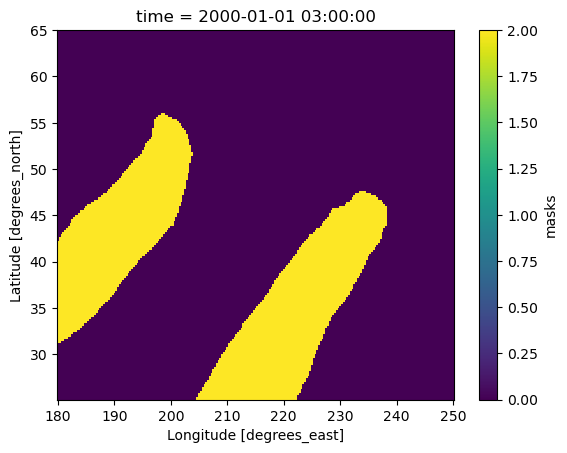

In [31]:
cnet_hist.isel(time=1).plot()

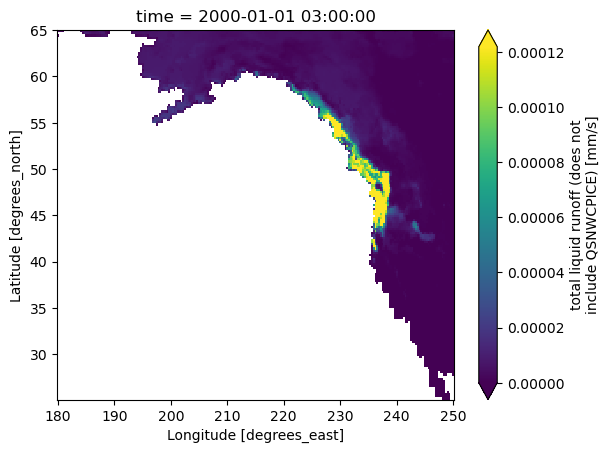

In [34]:
QRUNOFF_hist.isel(time=0).plot(robust=True)

In [35]:
client.close()

In [36]:
cluster.close()

## TO DO 
- QRUNOFF analysis
  - be careful with timeshift!
- CESM "IVT" output along with AR conditions
- circulation anomalies as in fronts analysis (wait for RCP8.5 masks)
- all the above for hist/RCP2.6, RCP8.5 and diffs